# Asthma Prediction Model
This notebook builds a machine learning model to predict asthma and asthma control levels

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [4]:
# Load the dataset
df = pd.read_csv('synthetic_asthma_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nTarget variable distribution:")
print(df['Has_Asthma'].value_counts())

Dataset shape: (10000, 17)

First few rows:
   Patient_ID  Age  Gender   BMI Smoking_Status  Family_History Allergies  \
0  ASTH100000   52  Female  27.6         Former               1       NaN   
1  ASTH100001   15    Male  24.6         Former               0      Dust   
2  ASTH100002   72  Female  17.6          Never               0       NaN   
3  ASTH100003   61    Male  16.8          Never               0  Multiple   
4  ASTH100004   21    Male  30.2          Never               0       NaN   

  Air_Pollution_Level Physical_Activity_Level Occupation_Type Comorbidities  \
0            Moderate               Sedentary         Outdoor      Diabetes   
1                 Low                Moderate          Indoor          Both   
2            Moderate                Moderate          Indoor           NaN   
3                High               Sedentary         Outdoor          Both   
4            Moderate                  Active          Indoor           NaN   

   Medication_Adhe

## Comprehensive Data Visualization

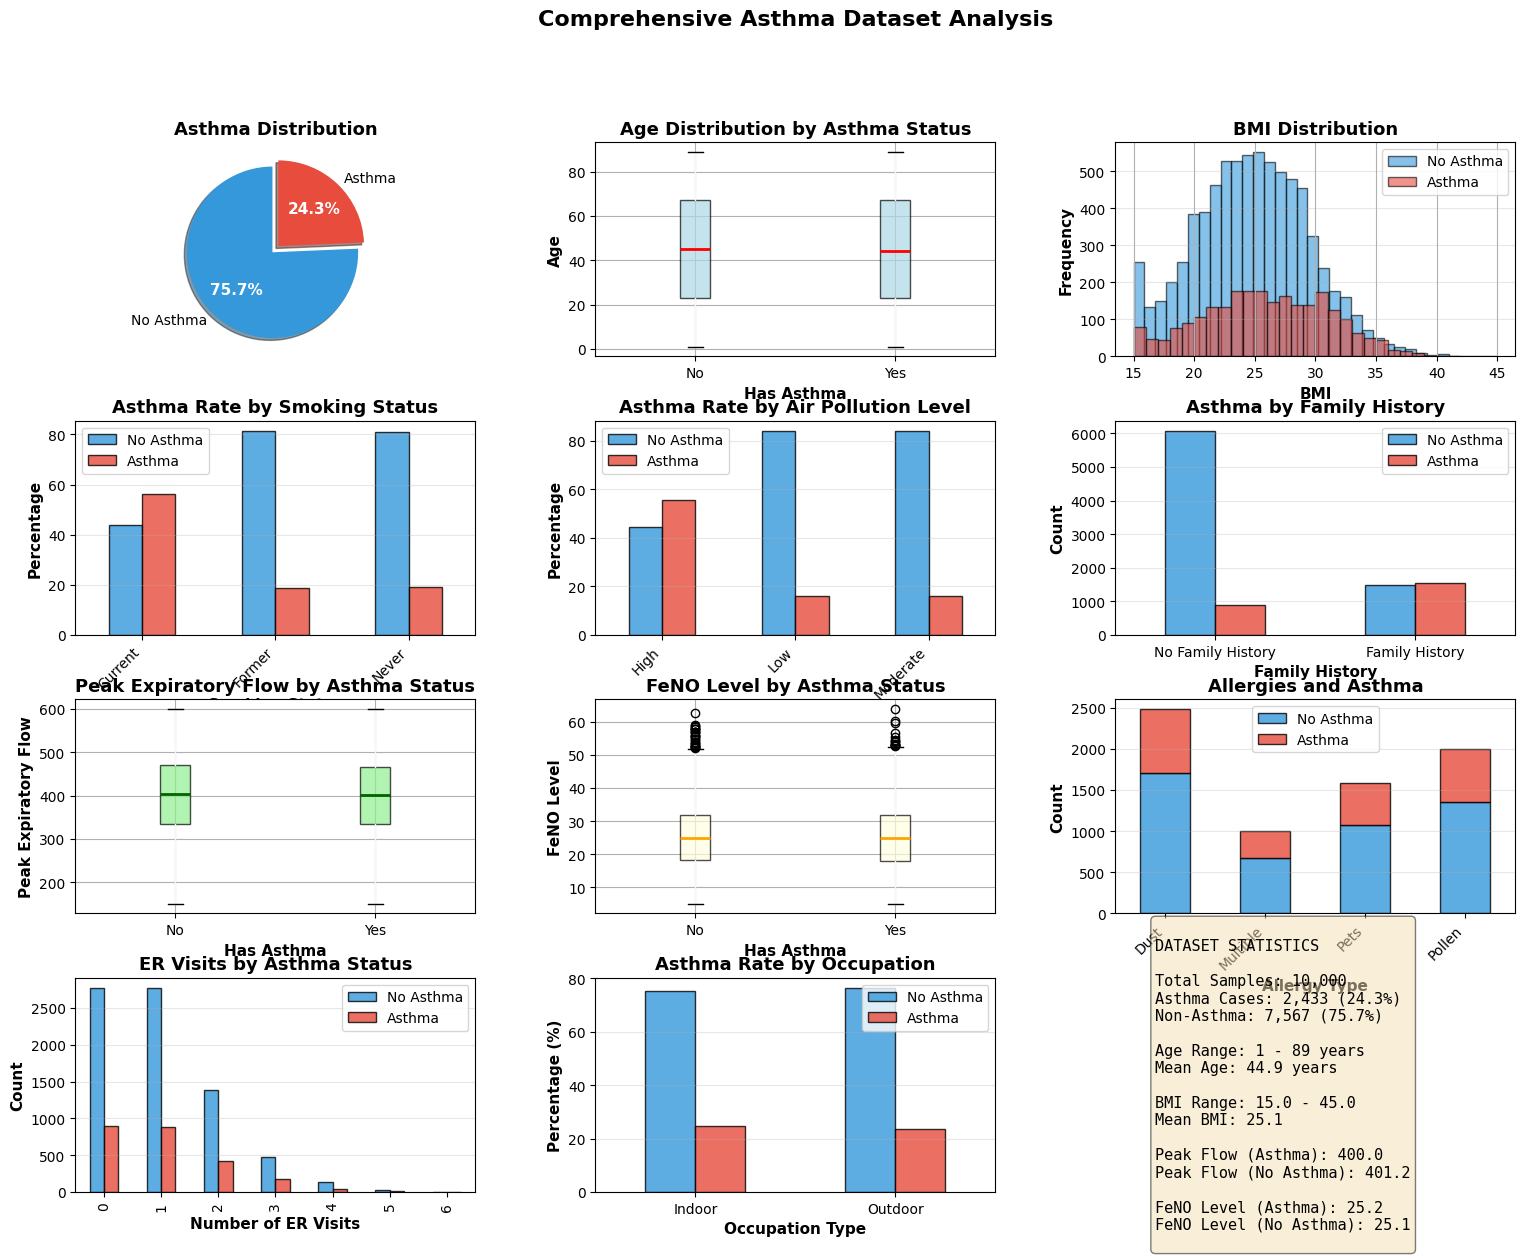

In [5]:
# Set visualization style
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Target variable distribution
ax1 = fig.add_subplot(gs[0, 0])
asthma_counts = df['Has_Asthma'].value_counts()
colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax1.pie(asthma_counts.values, labels=['No Asthma', 'Asthma'], 
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     explode=(0.05, 0.05), shadow=True)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(11)
ax1.set_title('Asthma Distribution', fontsize=13, weight='bold')

# 2. Age distribution by Asthma status
ax2 = fig.add_subplot(gs[0, 1])
df.boxplot(column='Age', by='Has_Asthma', ax=ax2, patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax2.set_xlabel('Has Asthma', fontsize=11, weight='bold')
ax2.set_ylabel('Age', fontsize=11, weight='bold')
ax2.set_title('Age Distribution by Asthma Status', fontsize=13, weight='bold')
ax2.set_xticklabels(['No', 'Yes'])
plt.suptitle('')  # Remove the automatic title

# 3. BMI distribution
ax3 = fig.add_subplot(gs[0, 2])
df[df['Has_Asthma']==0]['BMI'].hist(bins=30, alpha=0.6, label='No Asthma', 
                                      color='#3498db', ax=ax3, edgecolor='black')
df[df['Has_Asthma']==1]['BMI'].hist(bins=30, alpha=0.6, label='Asthma', 
                                      color='#e74c3c', ax=ax3, edgecolor='black')
ax3.set_xlabel('BMI', fontsize=11, weight='bold')
ax3.set_ylabel('Frequency', fontsize=11, weight='bold')
ax3.set_title('BMI Distribution', fontsize=13, weight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Smoking Status
ax4 = fig.add_subplot(gs[1, 0])
smoking_asthma = pd.crosstab(df['Smoking_Status'], df['Has_Asthma'], normalize='index') * 100
smoking_asthma.plot(kind='bar', ax=ax4, color=colors, alpha=0.8, edgecolor='black')
ax4.set_xlabel('Smoking Status', fontsize=11, weight='bold')
ax4.set_ylabel('Percentage', fontsize=11, weight='bold')
ax4.set_title('Asthma Rate by Smoking Status', fontsize=13, weight='bold')
ax4.legend(['No Asthma', 'Asthma'])
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 5. Air Pollution Level
ax5 = fig.add_subplot(gs[1, 1])
pollution_asthma = pd.crosstab(df['Air_Pollution_Level'], df['Has_Asthma'], normalize='index') * 100
pollution_asthma.plot(kind='bar', ax=ax5, color=colors, alpha=0.8, edgecolor='black')
ax5.set_xlabel('Air Pollution Level', fontsize=11, weight='bold')
ax5.set_ylabel('Percentage', fontsize=11, weight='bold')
ax5.set_title('Asthma Rate by Air Pollution Level', fontsize=13, weight='bold')
ax5.legend(['No Asthma', 'Asthma'])
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
ax5.grid(axis='y', alpha=0.3)

# 6. Family History
ax6 = fig.add_subplot(gs[1, 2])
family_history = pd.crosstab(df['Family_History'], df['Has_Asthma'])
family_history.plot(kind='bar', ax=ax6, color=colors, alpha=0.8, edgecolor='black')
ax6.set_xlabel('Family History', fontsize=11, weight='bold')
ax6.set_ylabel('Count', fontsize=11, weight='bold')
ax6.set_title('Asthma by Family History', fontsize=13, weight='bold')
ax6.legend(['No Asthma', 'Asthma'])
ax6.set_xticklabels(['No Family History', 'Family History'], rotation=0)
ax6.grid(axis='y', alpha=0.3)

# 7. Peak Expiratory Flow
ax7 = fig.add_subplot(gs[2, 0])
df.boxplot(column='Peak_Expiratory_Flow', by='Has_Asthma', ax=ax7, patch_artist=True,
           boxprops=dict(facecolor='lightgreen', alpha=0.7),
           medianprops=dict(color='darkgreen', linewidth=2))
ax7.set_xlabel('Has Asthma', fontsize=11, weight='bold')
ax7.set_ylabel('Peak Expiratory Flow', fontsize=11, weight='bold')
ax7.set_title('Peak Expiratory Flow by Asthma Status', fontsize=13, weight='bold')
ax7.set_xticklabels(['No', 'Yes'])
plt.suptitle('')

# 8. FeNO Level
ax8 = fig.add_subplot(gs[2, 1])
df.boxplot(column='FeNO_Level', by='Has_Asthma', ax=ax8, patch_artist=True,
           boxprops=dict(facecolor='lightyellow', alpha=0.7),
           medianprops=dict(color='orange', linewidth=2))
ax8.set_xlabel('Has Asthma', fontsize=11, weight='bold')
ax8.set_ylabel('FeNO Level', fontsize=11, weight='bold')
ax8.set_title('FeNO Level by Asthma Status', fontsize=13, weight='bold')
ax8.set_xticklabels(['No', 'Yes'])
plt.suptitle('')

# 9. Allergies
ax9 = fig.add_subplot(gs[2, 2])
allergies_counts = df.groupby(['Allergies', 'Has_Asthma']).size().unstack(fill_value=0)
allergies_counts.plot(kind='bar', stacked=True, ax=ax9, color=colors, alpha=0.8, edgecolor='black')
ax9.set_xlabel('Allergy Type', fontsize=11, weight='bold')
ax9.set_ylabel('Count', fontsize=11, weight='bold')
ax9.set_title('Allergies and Asthma', fontsize=13, weight='bold')
ax9.legend(['No Asthma', 'Asthma'])
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=45, ha='right')
ax9.grid(axis='y', alpha=0.3)

# 10. ER Visits distribution
ax10 = fig.add_subplot(gs[3, 0])
er_data = df.groupby(['Number_of_ER_Visits', 'Has_Asthma']).size().unstack(fill_value=0)
er_data.plot(kind='bar', ax=ax10, color=colors, alpha=0.8, edgecolor='black')
ax10.set_xlabel('Number of ER Visits', fontsize=11, weight='bold')
ax10.set_ylabel('Count', fontsize=11, weight='bold')
ax10.set_title('ER Visits by Asthma Status', fontsize=13, weight='bold')
ax10.legend(['No Asthma', 'Asthma'])
ax10.grid(axis='y', alpha=0.3)

# 11. Occupation Type
ax11 = fig.add_subplot(gs[3, 1])
occupation = pd.crosstab(df['Occupation_Type'], df['Has_Asthma'], normalize='index') * 100
occupation.plot(kind='bar', ax=ax11, color=colors, alpha=0.8, edgecolor='black')
ax11.set_xlabel('Occupation Type', fontsize=11, weight='bold')
ax11.set_ylabel('Percentage (%)', fontsize=11, weight='bold')
ax11.set_title('Asthma Rate by Occupation', fontsize=13, weight='bold')
ax11.legend(['No Asthma', 'Asthma'])
ax11.set_xticklabels(ax11.get_xticklabels(), rotation=0)
ax11.grid(axis='y', alpha=0.3)

# 12. Statistics summary
ax12 = fig.add_subplot(gs[3, 2])
ax12.axis('off')
stats_text = f"""
DATASET STATISTICS

Total Samples: {len(df):,}
Asthma Cases: {(df['Has_Asthma']==1).sum():,} ({(df['Has_Asthma']==1).sum()/len(df)*100:.1f}%)
Non-Asthma: {(df['Has_Asthma']==0).sum():,} ({(df['Has_Asthma']==0).sum()/len(df)*100:.1f}%)

Age Range: {df['Age'].min():.0f} - {df['Age'].max():.0f} years
Mean Age: {df['Age'].mean():.1f} years

BMI Range: {df['BMI'].min():.1f} - {df['BMI'].max():.1f}
Mean BMI: {df['BMI'].mean():.1f}

Peak Flow (Asthma): {df[df['Has_Asthma']==1]['Peak_Expiratory_Flow'].mean():.1f}
Peak Flow (No Asthma): {df[df['Has_Asthma']==0]['Peak_Expiratory_Flow'].mean():.1f}

FeNO Level (Asthma): {df[df['Has_Asthma']==1]['FeNO_Level'].mean():.1f}
FeNO Level (No Asthma): {df[df['Has_Asthma']==0]['FeNO_Level'].mean():.1f}
"""
ax12.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
          family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comprehensive Asthma Dataset Analysis', fontsize=16, weight='bold', y=0.995)
plt.show()

## Data Preprocessing

In [6]:
# Drop Patient_ID and Asthma_Control_Level (target for asthma patients only)
df_processed = df.drop(['Patient_ID', 'Asthma_Control_Level'], axis=1)

# Encode categorical variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

print(f"Encoded categorical columns: {list(categorical_cols)}")
print(f"\nProcessed data shape: {df_processed.shape}")

Encoded categorical columns: ['Gender', 'Smoking_Status', 'Allergies', 'Air_Pollution_Level', 'Physical_Activity_Level', 'Occupation_Type', 'Comorbidities']

Processed data shape: (10000, 15)


## Exploratory Data Analysis & Feature Selection by Correlation


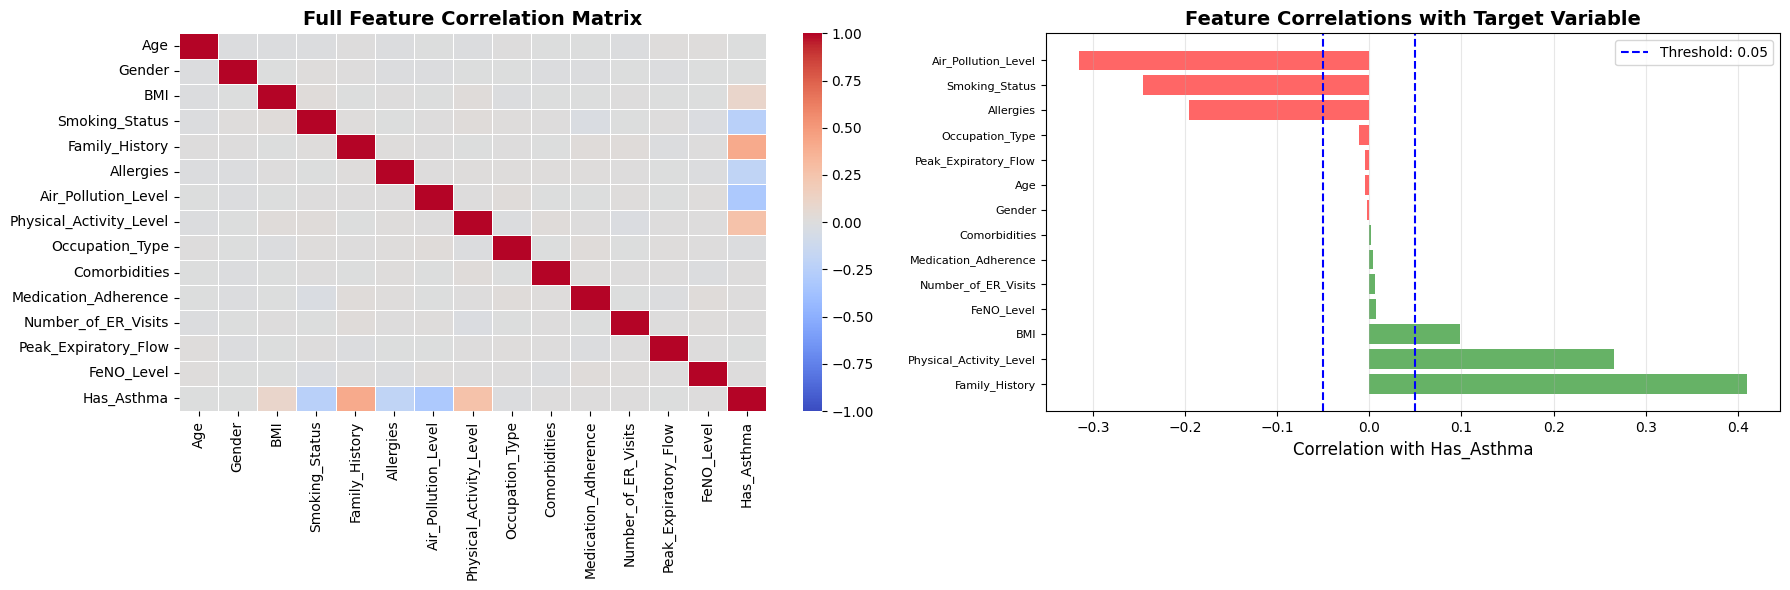


✓ Feature selection complete!
✓ 6 features selected with |correlation| > 0.05
✓ Selected features stored in variable: selected_features_corr


In [7]:
# Calculate correlation matrix
correlation_matrix = df_processed.corr()

# Get correlation with target variable
target_corr = correlation_matrix['Has_Asthma'].sort_values(ascending=False)

# Set threshold for correlation-based feature selection
correlation_threshold = 0.05

# Select features that correlate with Has_Asthma above the threshold
selected_features_corr = target_corr[abs(target_corr) > correlation_threshold].index.tolist()
if 'Has_Asthma' in selected_features_corr:
    selected_features_corr.remove('Has_Asthma')

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Full Correlation Heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Full Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 2. Correlation with Target (Has_Asthma) - Bar Plot
target_corr_sorted = target_corr.drop('Has_Asthma')
colors = ['red' if x < 0 else 'green' for x in target_corr_sorted.values]
axes[1].barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors, alpha=0.6)
axes[1].set_yticks(range(len(target_corr_sorted)))
axes[1].set_yticklabels(target_corr_sorted.index, fontsize=8)
axes[1].axvline(x=correlation_threshold, color='blue', linestyle='--', label=f'Threshold: {correlation_threshold}')
axes[1].axvline(x=-correlation_threshold, color='blue', linestyle='--')
axes[1].set_xlabel('Correlation with Has_Asthma', fontsize=12)
axes[1].set_title('Feature Correlations with Target Variable', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Feature selection complete!")
print(f"✓ {len(selected_features_corr)} features selected with |correlation| > {correlation_threshold}")
print(f"✓ Selected features stored in variable: selected_features_corr")

## Split Data and Scale Features

In [8]:
# Separate features and target
X = df_processed.drop('Has_Asthma', axis=1)
y = df_processed['Has_Asthma']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Class distribution in training: {y_train.value_counts()}")

Training set: (8000, 14)
Test set: (2000, 14)
Class distribution in training: Has_Asthma
0    6054
1    1946
Name: count, dtype: int64


In [9]:
# Train Logistic Regression with Hyperparameter Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

# Create base model
lr_base = LogisticRegression(random_state=3, n_jobs=-1)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting hyperparameter tuning for Logistic Regression...")
grid_search.fit(X_train_scaled, y_train)

# Best model
lr_model = grid_search.best_estimator_

print(f"\n{'='*60}")
print("HYPERPARAMETER TUNING RESULTS")
print(f"{'='*60}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.4f}")
print(f"{'='*60}\n")

# Predictions for both train and test
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_proba_lr_train = lr_model.predict_proba(X_train_scaled)[:, 1]

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Results (with Hyperparameter Tuning):")
print("\nTRAIN SET:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_lr_train):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_train, y_pred_proba_lr_train):.4f}")
print("\nTEST SET:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"\nClassification Report (Test Set):\n{classification_report(y_test, y_pred_lr)}")

Starting hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

HYPERPARAMETER TUNING RESULTS
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation ROC-AUC: 0.9475

Logistic Regression Results (with Hyperparameter Tuning):

TRAIN SET:
Accuracy: 0.8842
ROC-AUC Score: 0.9479

TEST SET:
Accuracy: 0.8755
ROC-AUC Score: 0.9375

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1513
           1       0.77      0.70      0.73       487

    accuracy                           0.88      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.87      0.88      0.87      2000


HYPERPARAMETER TUNING RESULTS
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation ROC-AUC: 0.9475

Logistic Regression Results (with Hyperparamete

c:\Users\aleni\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


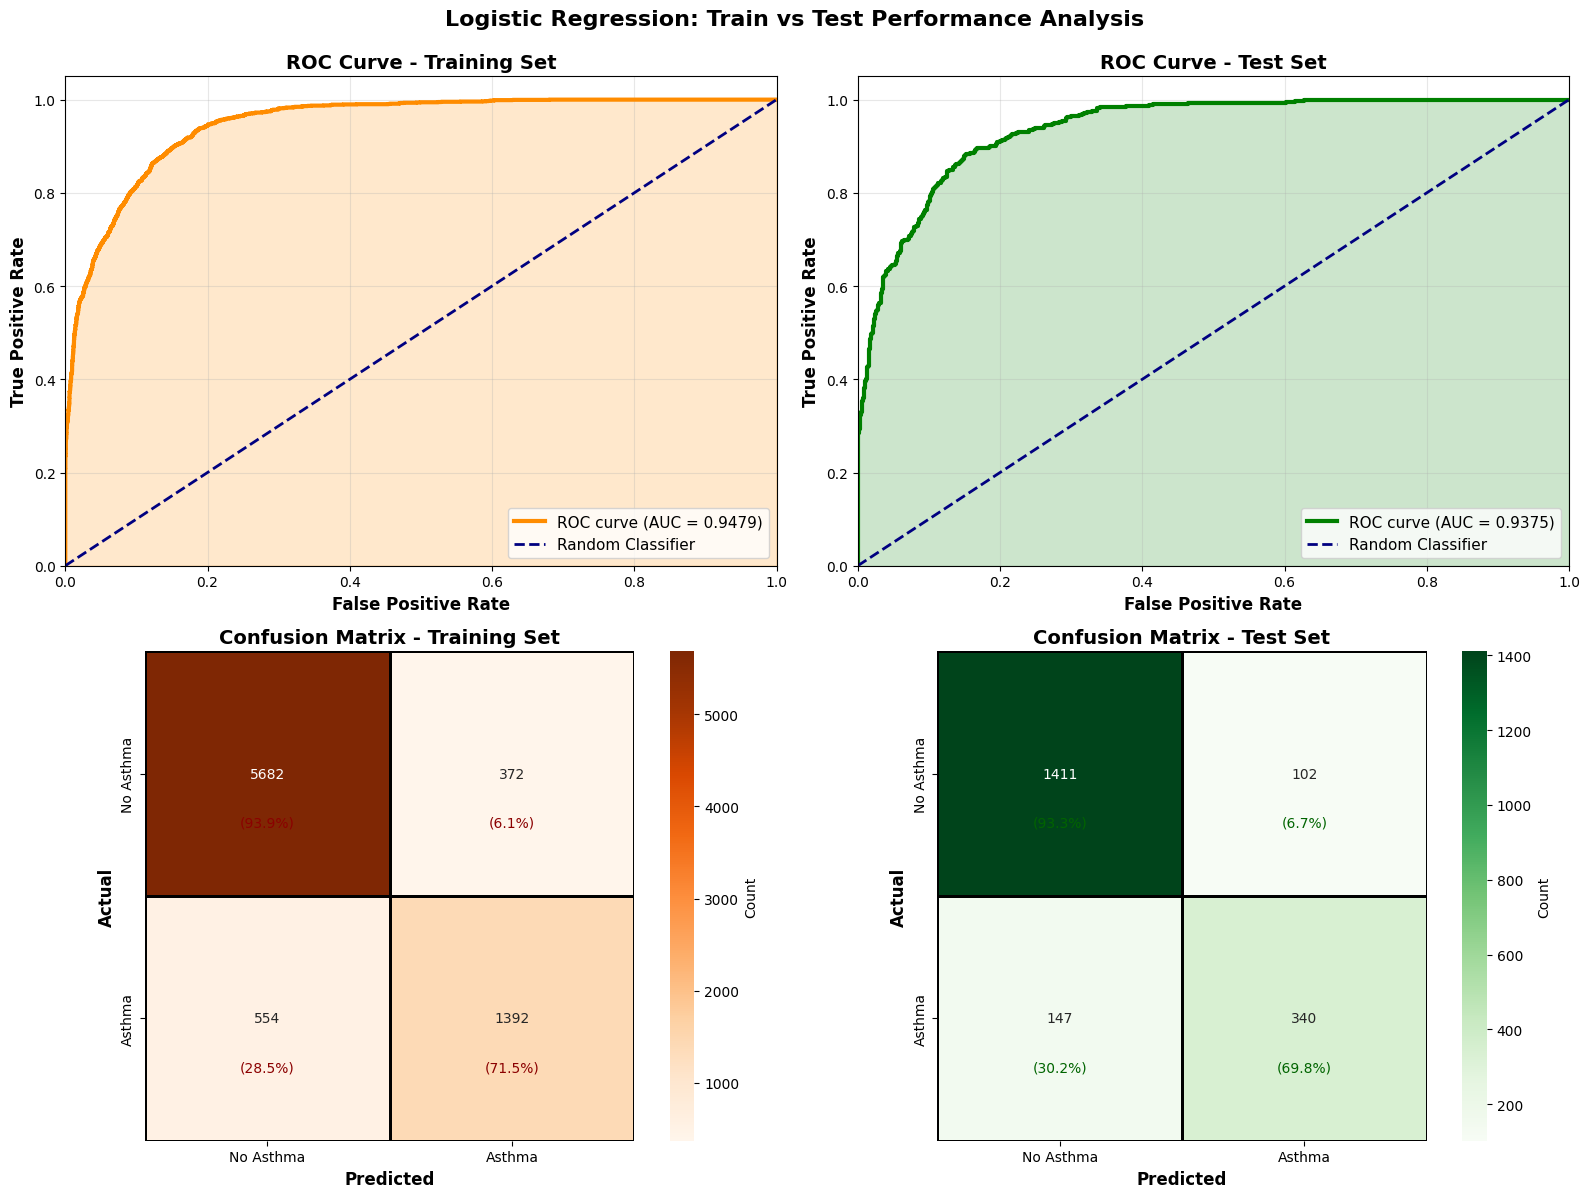


LOGISTIC REGRESSION PERFORMANCE SUMMARY

TRAINING SET:
  Accuracy:  0.8842
  ROC-AUC:   0.9479

TEST SET:
  Accuracy:  0.8755
  ROC-AUC:   0.9375



In [10]:
# Visualizations: Train vs Test Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve - Training Set
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_lr_train)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_lr_train)

axes[0, 0].plot(fpr_train, tpr_train, color='darkorange', lw=3, 
                label=f'ROC curve (AUC = {roc_auc_train:.4f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 0].fill_between(fpr_train, tpr_train, alpha=0.2, color='darkorange')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, weight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, weight='bold')
axes[0, 0].set_title('ROC Curve - Training Set', fontsize=14, weight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. ROC Curve - Test Set
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_lr)

axes[0, 1].plot(fpr_test, tpr_test, color='green', lw=3, 
                label=f'ROC curve (AUC = {roc_auc_test:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].fill_between(fpr_test, tpr_test, alpha=0.2, color='green')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12, weight='bold')
axes[0, 1].set_title('ROC Curve - Test Set', fontsize=14, weight='bold')
axes[0, 1].legend(loc='lower right', fontsize=11)
axes[0, 1].grid(alpha=0.3)

# 3. Confusion Matrix - Training Set
cm_train = confusion_matrix(y_train, y_pred_lr_train)
cm_train_percent = cm_train.astype(float) / cm_train.sum(axis=1, keepdims=True) * 100

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Oranges', cbar=True, ax=axes[1, 0], 
            square=True, linewidths=2, linecolor='black', cbar_kws={'label': 'Count'})
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        axes[1, 0].text(j + 0.5, i + 0.7, f'({cm_train_percent[i, j]:.1f}%)', 
                       ha='center', va='center', fontsize=10, color='darkred')
axes[1, 0].set_xlabel('Predicted', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Actual', fontsize=12, weight='bold')
axes[1, 0].set_title('Confusion Matrix - Training Set', fontsize=14, weight='bold')
axes[1, 0].set_xticklabels(['No Asthma', 'Asthma'])
axes[1, 0].set_yticklabels(['No Asthma', 'Asthma'])

# 4. Confusion Matrix - Test Set
cm_test = confusion_matrix(y_test, y_pred_lr)
cm_test_percent = cm_test.astype(float) / cm_test.sum(axis=1, keepdims=True) * 100

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=True, ax=axes[1, 1], 
            square=True, linewidths=2, linecolor='black', cbar_kws={'label': 'Count'})
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        axes[1, 1].text(j + 0.5, i + 0.7, f'({cm_test_percent[i, j]:.1f}%)', 
                       ha='center', va='center', fontsize=10, color='darkgreen')
axes[1, 1].set_xlabel('Predicted', fontsize=12, weight='bold')
axes[1, 1].set_ylabel('Actual', fontsize=12, weight='bold')
axes[1, 1].set_title('Confusion Matrix - Test Set', fontsize=14, weight='bold')
axes[1, 1].set_xticklabels(['No Asthma', 'Asthma'])
axes[1, 1].set_yticklabels(['No Asthma', 'Asthma'])

plt.suptitle('Logistic Regression: Train vs Test Performance Analysis', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Performance Summary
print("\n" + "="*70)
print("LOGISTIC REGRESSION PERFORMANCE SUMMARY")
print("="*70)
print(f"\nTRAINING SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_pred_lr_train):.4f}")
print(f"  ROC-AUC:   {roc_auc_train:.4f}")
print(f"\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  ROC-AUC:   {roc_auc_test:.4f}")
print("\n" + "="*70)

## Model 2: Decision Tree Classifier

In [11]:
# Train Decision Tree with Hyperparameter Tuning
from sklearn.tree import DecisionTreeClassifier

# Define hyperparameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, ],
    'min_samples_split': [2, 5 , 10 , 20],
    'criterion': ['entropy'],
    'splitter': ['best']
}

# Create selected feature datasets for Decision Tree
selected_indices = [X.columns.get_loc(col) for col in selected_features_corr]
X_train_selected = X_train_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]

print(f"Using {len(selected_features_corr)} selected features for Decision Tree: {selected_features_corr}")
print(f"Selected features shape: {X_train_selected.shape}")

# Create base Decision Tree model
dt_base = DecisionTreeClassifier(random_state=3)

# GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=dt_param_grid,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting hyperparameter tuning for Decision Tree...")
dt_grid_search.fit(X_train_selected, y_train)

# Best model
dt_model = dt_grid_search.best_estimator_

print(f"\n{'='*60}")
print("DECISION TREE HYPERPARAMETER TUNING RESULTS")
print(f"{'='*60}")
print(f"Best parameters: {dt_grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC: {dt_grid_search.best_score_:.4f}")
print(f"{'='*60}\n")

# Predictions for both train and test using selected features
y_pred_dt_train = dt_model.predict(X_train_selected)
y_pred_proba_dt_train = dt_model.predict_proba(X_train_selected)[:, 1]

y_pred_dt = dt_model.predict(X_test_selected)
y_pred_proba_dt = dt_model.predict_proba(X_test_selected)[:, 1]

# Evaluation
print("Decision Tree Classifier Results (with Hyperparameter Tuning and Feature Selection):")
print("\nTRAIN SET:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_dt_train):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_train, y_pred_proba_dt_train):.4f}")
print("\nTEST SET:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")
print(f"\nClassification Report (Test Set):\n{classification_report(y_test, y_pred_dt)}")

Using 6 selected features for Decision Tree: ['Family_History', 'Physical_Activity_Level', 'BMI', 'Allergies', 'Smoking_Status', 'Air_Pollution_Level']
Selected features shape: (8000, 6)
Starting hyperparameter tuning for Decision Tree...
Fitting 10 folds for each of 20 candidates, totalling 200 fits



DECISION TREE HYPERPARAMETER TUNING RESULTS
Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation ROC-AUC: 0.9995

Decision Tree Classifier Results (with Hyperparameter Tuning and Feature Selection):

TRAIN SET:
Accuracy: 1.0000
ROC-AUC Score: 1.0000

TEST SET:
Accuracy: 0.9995
ROC-AUC Score: 0.9997

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1513
           1       1.00      1.00      1.00       487

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



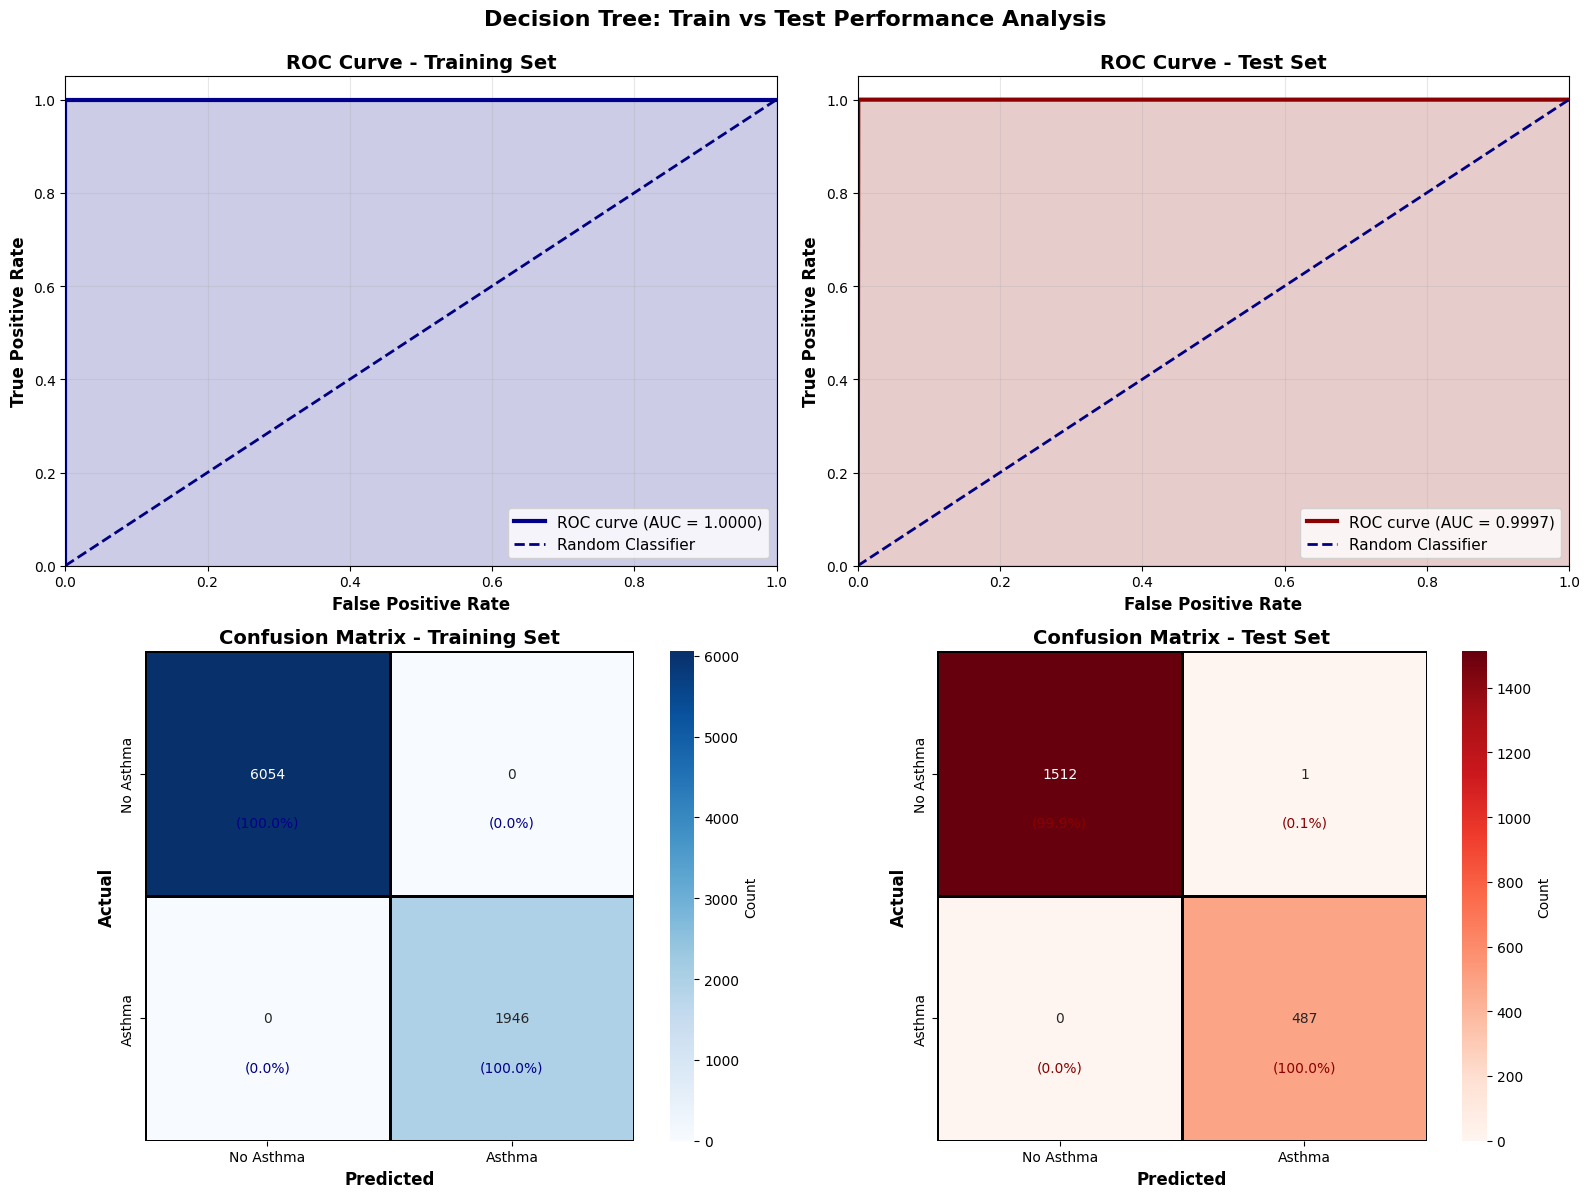


DECISION TREE PERFORMANCE SUMMARY

TRAINING SET:
  Accuracy:  1.0000
  ROC-AUC:   1.0000

TEST SET:
  Accuracy:  0.9995
  ROC-AUC:   0.9997



In [12]:
# Visualizations: Decision Tree Train vs Test Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve - Training Set
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_pred_proba_dt_train)
roc_auc_dt_train = roc_auc_score(y_train, y_pred_proba_dt_train)

axes[0, 0].plot(fpr_dt_train, tpr_dt_train, color='darkblue', lw=3, 
                label=f'ROC curve (AUC = {roc_auc_dt_train:.4f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 0].fill_between(fpr_dt_train, tpr_dt_train, alpha=0.2, color='darkblue')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, weight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, weight='bold')
axes[0, 0].set_title('ROC Curve - Training Set', fontsize=14, weight='bold')
axes[0, 0].legend(loc='lower right', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. ROC Curve - Test Set
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt_test = roc_auc_score(y_test, y_pred_proba_dt)

axes[0, 1].plot(fpr_dt_test, tpr_dt_test, color='darkred', lw=3, 
                label=f'ROC curve (AUC = {roc_auc_dt_test:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].fill_between(fpr_dt_test, tpr_dt_test, alpha=0.2, color='darkred')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12, weight='bold')
axes[0, 1].set_title('ROC Curve - Test Set', fontsize=14, weight='bold')
axes[0, 1].legend(loc='lower right', fontsize=11)
axes[0, 1].grid(alpha=0.3)

# 3. Confusion Matrix - Training Set
cm_dt_train = confusion_matrix(y_train, y_pred_dt_train)
cm_dt_train_percent = cm_dt_train.astype(float) / cm_dt_train.sum(axis=1, keepdims=True) * 100

sns.heatmap(cm_dt_train, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[1, 0], 
            square=True, linewidths=2, linecolor='black', cbar_kws={'label': 'Count'})
for i in range(cm_dt_train.shape[0]):
    for j in range(cm_dt_train.shape[1]):
        axes[1, 0].text(j + 0.5, i + 0.7, f'({cm_dt_train_percent[i, j]:.1f}%)', 
                       ha='center', va='center', fontsize=10, color='darkblue')
axes[1, 0].set_xlabel('Predicted', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Actual', fontsize=12, weight='bold')
axes[1, 0].set_title('Confusion Matrix - Training Set', fontsize=14, weight='bold')
axes[1, 0].set_xticklabels(['No Asthma', 'Asthma'])
axes[1, 0].set_yticklabels(['No Asthma', 'Asthma'])

# 4. Confusion Matrix - Test Set
cm_dt_test = confusion_matrix(y_test, y_pred_dt)
cm_dt_test_percent = cm_dt_test.astype(float) / cm_dt_test.sum(axis=1, keepdims=True) * 100

sns.heatmap(cm_dt_test, annot=True, fmt='d', cmap='Reds', cbar=True, ax=axes[1, 1], 
            square=True, linewidths=2, linecolor='black', cbar_kws={'label': 'Count'})
for i in range(cm_dt_test.shape[0]):
    for j in range(cm_dt_test.shape[1]):
        axes[1, 1].text(j + 0.5, i + 0.7, f'({cm_dt_test_percent[i, j]:.1f}%)', 
                       ha='center', va='center', fontsize=10, color='darkred')
axes[1, 1].set_xlabel('Predicted', fontsize=12, weight='bold')
axes[1, 1].set_ylabel('Actual', fontsize=12, weight='bold')
axes[1, 1].set_title('Confusion Matrix - Test Set', fontsize=14, weight='bold')
axes[1, 1].set_xticklabels(['No Asthma', 'Asthma'])
axes[1, 1].set_yticklabels(['No Asthma', 'Asthma'])

plt.suptitle('Decision Tree: Train vs Test Performance Analysis', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Performance Summary
print("\n" + "="*70)
print("DECISION TREE PERFORMANCE SUMMARY")
print("="*70)
print(f"\nTRAINING SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_pred_dt_train):.4f}")
print(f"  ROC-AUC:   {roc_auc_dt_train:.4f}")
print(f"\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"  ROC-AUC:   {roc_auc_dt_test:.4f}")
print("\n" + "="*70)

## Comprehensive Model Evaluation: Train vs Test Performance

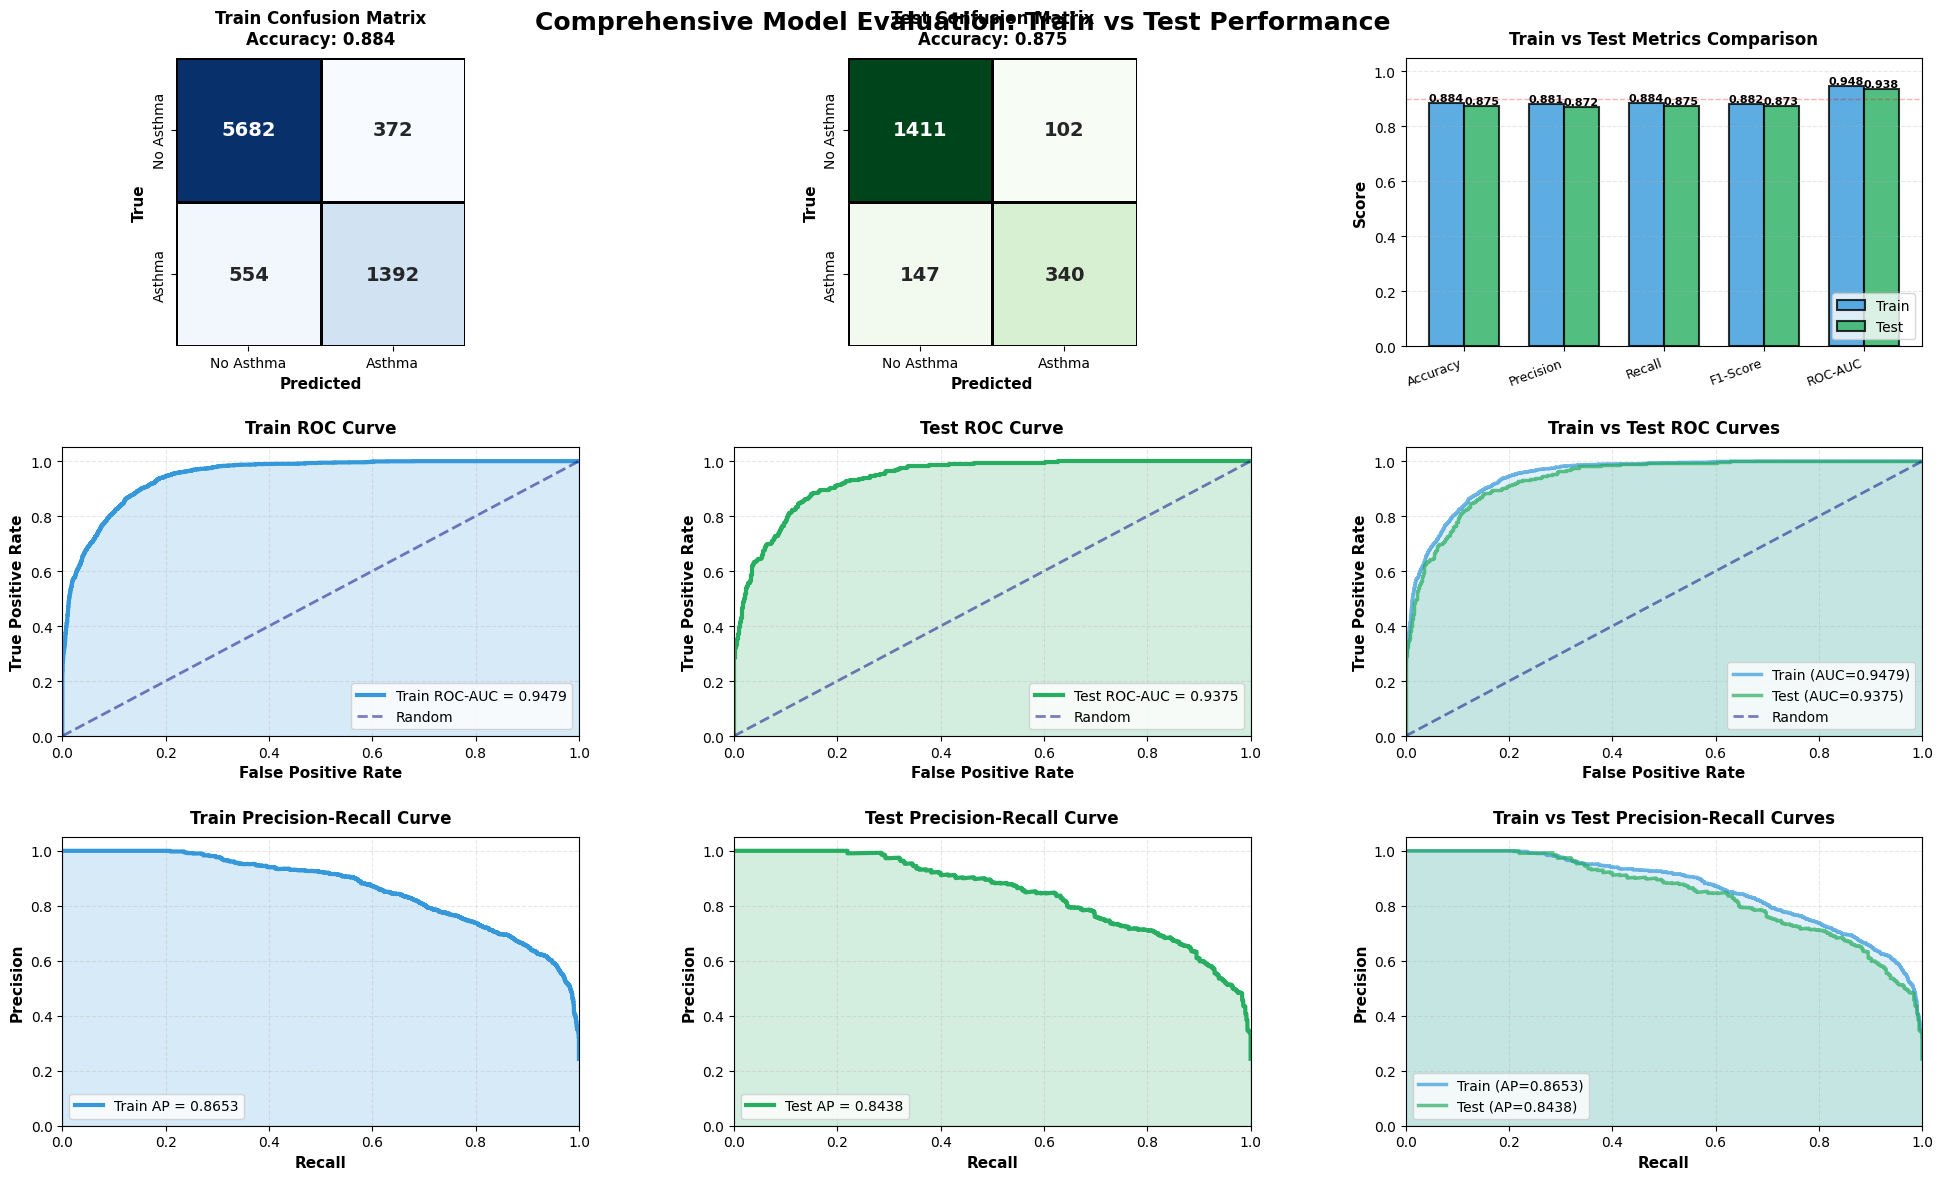


COMPREHENSIVE PERFORMANCE SUMMARY

Metric                    Train           Test            Difference     
----------------------------------------------------------------------
Accuracy                  0.8842          0.8755          0.0088         
Precision                 0.8815          0.8724          0.0090         
Recall                    0.8842          0.8755          0.0088         
F1-Score                  0.8823          0.8734          0.0089         
ROC-AUC                   0.9479          0.9375          0.0104         
Average Precision         0.8653          0.8438          0.0214         


In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate predictions and probabilities using lr_model
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)
y_train_prob = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# ROC curve calculations
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
train_auc = auc(fpr_train, tpr_train)
test_auc = auc(fpr_test, tpr_test)

# Precision-Recall curve calculations
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_prob)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_prob)
train_ap = average_precision_score(y_train, y_train_prob)
test_ap = average_precision_score(y_test, y_test_prob)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Comprehensive Model Evaluation: Train vs Test Performance', 
             fontsize=18, weight='bold', y=0.98)

# Define grid
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, top=0.94, bottom=0.05, left=0.05, right=0.98)

# 1. Train Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Asthma', 'Asthma'], yticklabels=['No Asthma', 'Asthma'], 
            ax=ax1, square=True, linewidths=2, linecolor='black', annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted', fontsize=11, weight='bold')
ax1.set_ylabel('True', fontsize=11, weight='bold')
ax1.set_title(f'Train Confusion Matrix\nAccuracy: {train_accuracy:.3f}', 
              fontsize=12, weight='bold', pad=10)

# 2. Test Confusion Matrix
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Asthma', 'Asthma'], yticklabels=['No Asthma', 'Asthma'],
            ax=ax2, square=True, linewidths=2, linecolor='black', annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_xlabel('Predicted', fontsize=11, weight='bold')
ax2.set_ylabel('True', fontsize=11, weight='bold')
ax2.set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracy:.3f}', 
              fontsize=12, weight='bold', pad=10)

# 3. Metrics Comparison Bar Chart
ax3 = fig.add_subplot(gs[0, 2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_scores = [train_accuracy, train_precision, train_recall, train_f1, train_auc]
test_scores = [test_accuracy, test_precision, test_recall, test_f1, test_auc]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax3.bar(x - width/2, train_scores, width, label='Train', 
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x + width/2, test_scores, width, label='Test', 
                color='#27ae60', alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Score', fontsize=11, weight='bold')
ax3.set_title('Train vs Test Metrics Comparison', fontsize=12, weight='bold', pad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names, rotation=20, ha='right', fontsize=9)
ax3.legend(fontsize=10, loc='lower right')
ax3.set_ylim([0, 1.05])
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.axhline(y=0.9, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, weight='bold')

# 4. Train ROC Curve
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(fpr_train, tpr_train, color='#3498db', lw=3, 
         label=f'Train ROC-AUC = {train_auc:.4f}')
ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax4.fill_between(fpr_train, tpr_train, alpha=0.2, color='#3498db')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax4.set_title('Train ROC Curve', fontsize=12, weight='bold', pad=10)
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(alpha=0.3, linestyle='--')

# 5. Test ROC Curve
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(fpr_test, tpr_test, color='#27ae60', lw=3, 
         label=f'Test ROC-AUC = {test_auc:.4f}')
ax5.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax5.fill_between(fpr_test, tpr_test, alpha=0.2, color='#27ae60')
ax5.set_xlim([0.0, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax5.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax5.set_title('Test ROC Curve', fontsize=12, weight='bold', pad=10)
ax5.legend(loc='lower right', fontsize=10)
ax5.grid(alpha=0.3, linestyle='--')

# 6. Train vs Test ROC Curves (Combined)
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(fpr_train, tpr_train, color='#3498db', lw=2.5, alpha=0.7,
         label=f'Train (AUC={train_auc:.4f})')
ax6.plot(fpr_test, tpr_test, color='#27ae60', lw=2.5, alpha=0.7,
         label=f'Test (AUC={test_auc:.4f})')
ax6.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax6.fill_between(fpr_train, tpr_train, alpha=0.15, color='#3498db')
ax6.fill_between(fpr_test, tpr_test, alpha=0.15, color='#27ae60')
ax6.set_xlim([0.0, 1.0])
ax6.set_ylim([0.0, 1.05])
ax6.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax6.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax6.set_title('Train vs Test ROC Curves', fontsize=12, weight='bold', pad=10)
ax6.legend(loc='lower right', fontsize=10)
ax6.grid(alpha=0.3, linestyle='--')

# 7. Train Precision-Recall Curve
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(recall_train, precision_train, color='#3498db', lw=3,
         label=f'Train AP = {train_ap:.4f}')
ax7.fill_between(recall_train, precision_train, alpha=0.2, color='#3498db')
ax7.set_xlim([0.0, 1.0])
ax7.set_ylim([0.0, 1.05])
ax7.set_xlabel('Recall', fontsize=11, weight='bold')
ax7.set_ylabel('Precision', fontsize=11, weight='bold')
ax7.set_title('Train Precision-Recall Curve', fontsize=12, weight='bold', pad=10)
ax7.legend(loc='lower left', fontsize=10)
ax7.grid(alpha=0.3, linestyle='--')

# 8. Test Precision-Recall Curve
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(recall_test, precision_test, color='#27ae60', lw=3,
         label=f'Test AP = {test_ap:.4f}')
ax8.fill_between(recall_test, precision_test, alpha=0.2, color='#27ae60')
ax8.set_xlim([0.0, 1.0])
ax8.set_ylim([0.0, 1.05])
ax8.set_xlabel('Recall', fontsize=11, weight='bold')
ax8.set_ylabel('Precision', fontsize=11, weight='bold')
ax8.set_title('Test Precision-Recall Curve', fontsize=12, weight='bold', pad=10)
ax8.legend(loc='lower left', fontsize=10)
ax8.grid(alpha=0.3, linestyle='--')

# 9. Train vs Test Precision-Recall Curves (Combined)
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(recall_train, precision_train, color='#3498db', lw=2.5, alpha=0.7,
         label=f'Train (AP={train_ap:.4f})')
ax9.plot(recall_test, precision_test, color='#27ae60', lw=2.5, alpha=0.7,
         label=f'Test (AP={test_ap:.4f})')
ax9.fill_between(recall_train, precision_train, alpha=0.15, color='#3498db')
ax9.fill_between(recall_test, precision_test, alpha=0.15, color='#27ae60')
ax9.set_xlim([0.0, 1.0])
ax9.set_ylim([0.0, 1.05])
ax9.set_xlabel('Recall', fontsize=11, weight='bold')
ax9.set_ylabel('Precision', fontsize=11, weight='bold')
ax9.set_title('Train vs Test Precision-Recall Curves', fontsize=12, weight='bold', pad=10)
ax9.legend(loc='lower left', fontsize=10)
ax9.grid(alpha=0.3, linestyle='--')

plt.show()

# Print summary statistics
print("\n" + "="*70)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*70)
print(f"\n{'Metric':<25} {'Train':<15} {'Test':<15} {'Difference':<15}")
print("-"*70)
print(f"{'Accuracy':<25} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(train_accuracy-test_accuracy):<15.4f}")
print(f"{'Precision':<25} {train_precision:<15.4f} {test_precision:<15.4f} {abs(train_precision-test_precision):<15.4f}")
print(f"{'Recall':<25} {train_recall:<15.4f} {test_recall:<15.4f} {abs(train_recall-test_recall):<15.4f}")
print(f"{'F1-Score':<25} {train_f1:<15.4f} {test_f1:<15.4f} {abs(train_f1-test_f1):<15.4f}")
print(f"{'ROC-AUC':<25} {train_auc:<15.4f} {test_auc:<15.4f} {abs(train_auc-test_auc):<15.4f}")
print(f"{'Average Precision':<25} {train_ap:<15.4f} {test_ap:<15.4f} {abs(train_ap-test_ap):<15.4f}")
print("="*70)